In [4]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from collections import deque

In [5]:
# Enums
class Color(Enum):
    RED = 0
    BLUE = 1
    YELLOW = 2
    GREEN = 3
    BLACK = 4

class Label(Enum):
    DANGEROUS = 0
    SAFE = 1

COLOR_TO_RGB = {
    0 : (255, 0, 0),
    1 : (0, 0, 255),
    2 : (255, 255, 0),
    3 : (0, 255, 0),
    4 : (0, 0, 0)
}

In [6]:
# Image Generation
class Image: # USE THIS CLASS TO DISPLAY / CREATE IMAGE
    def __init__(self, data, label, third_wire):
        self.data = data
        self.label = label
        self.third_wire = third_wire

    def display(self):
        n = self.data.shape[0]
        image_data = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                curr_val = self.data[i][j]
                image_data[i][j] = COLOR_TO_RGB[curr_val]

        plt.imshow(image_data)
        plt.axis("off")
        plt.show()

class DataSet:
    def __init__(self):
        self.image_data = []
        self.labels = []
        self.third_wires = []

    def add_image(self, image, label, third_wire):
        """Add an image to the dataset using raw data"""
        self.image_data.append(image)
        self.labels.append(label.value)
        self.third_wires.append(third_wire) 

class ImageGenerator:
    """Generates N (M x M) images and writes to data"""
    def __init__(self, num_images, dimensions = 20, write_path = None, dataset = None, seed = None):
        self.dimensions = dimensions
        self.seed = seed
        random.seed(seed)
        for _ in range(num_images):
            data, label, third_wire = self.generate(write_path is not None)
            if dataset is not None:
                dataset.add_image(data, label, third_wire)

            # TODO: Write to data (may not be necessary, gen is really fast)
            if write_path is not None:
                pass

    def generate(self, write_ = False):
        """Generate a single image and label it appropriately"""
        n = self.dimensions
        image_data = np.full((n, n), Color.BLACK.value)
        colors = [Color.RED, Color.BLUE, Color.YELLOW, Color.GREEN]

        # Keep track of rows/cols that can be used
        valid_rows = list(range(n))
        valid_cols = list(range(n))

        # 1  = Color Row
        # -1 = Color Col
        pointer = random.choice([1, -1])
        label = Label.SAFE
        yellow_placed = False
        third_wire = None

        for i in range(4):
            # Select a unused color
            curr_color = random.choice(colors)
            colors.remove(curr_color)

            # Determine which should be cut (if dangerous)
            if i == 2:
                third_wire = curr_color
            
            # Handle marking an image as DANGEROUS if red is placed before yellow
            yellow_placed = yellow_placed or curr_color == Color.YELLOW
            if curr_color == Color.RED and not yellow_placed:
                label = Label.DANGEROUS

            if pointer == 1:
                rand_idx = random.choice(valid_rows)
                valid_rows.remove(rand_idx)
                self.color_row(rand_idx, curr_color, image_data)
            else:
                rand_idx = random.choice(valid_cols)
                valid_cols.remove(rand_idx)
                self.color_column(rand_idx, curr_color, image_data)
                
            pointer *= -1
        
        return image_data, label, third_wire
            

    def color_column(self, col, color, arr):
        """Color the given column of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[i][col] = color.value

    def color_row(self, row, color, arr):
        """Color the given row of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[row][i] = color.value

In [7]:
# Helper Functions
def load_image(dataset_obj, index):
    """Load a specific index of the dataset"""
    image_data = dataset_obj.image_data[index]
    label = dataset_obj.labels[index]
    third_wire = dataset_obj.third_wires[index]
    img = Image(image_data, label, third_wire)
    return img

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def train_test_validation_split(X, y, train_size = .8, test_size = .1, validation_size = .1):
    if train_size + test_size + validation_size != 1:
        print("Error: train + test + validation don't add up to 1.")
        return
    
    print(X.shape)
    examples, features = X.shape
    # Randomize Indexes
    index_array = np.arange(examples)
    random.shuffle(index_array)

    # Split up data
    num_training = int(examples * train_size)
    num_testing = int(examples * test_size)
    train_indices = index_array[:num_training]
    test_indices = index_array[num_training:(num_training + num_testing)]
    validation_indices = index_array[(num_training + num_testing):]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    X_validation = X[validation_indices]
    y_validation = y[validation_indices]

    return X_train, y_train, X_test, y_test, X_validation, y_validation

def one_hot_encode(image_data):
    """One-Hot encode matrix of examples"""
    if not isinstance(image_data, np.ndarray):
        image_data = np.array(image_data)

    num_colors = 4
    examples, rows, cols = image_data.shape
    encoded_shape = (examples, rows, cols, num_colors)
    encoded_image = np.zeros(encoded_shape)
    for i in range(examples):
        for j in range(rows):
            for k in range(cols):
                for l in range(num_colors):
                    if l == image_data[i, j, k]:
                        encoded_image[i, j, k, l] = 1
                    
    return encoded_image

def preprocess_data(image_data, label_data):
    """Preprocess and encode image and label data for model training"""
    image_data = one_hot_encode(image_data)
    label_data = np.array(label_data)
    flattened_data = image_data.reshape(image_data.shape[0], -1)
    flattened_data = np.c_[np.ones(len(flattened_data)), flattened_data] 
    return flattened_data, label_data
    
def plot_data(title, x_label, y_label, data):
    """Data should be either a list or tuple, where the list is a list of tuples.
    
    Tuple format: Data to be plotted, name of data"""
    fig, ax = plt.subplots()
    
    if isinstance(data, list):
        for d in data:
            ax.plot(d[0], label = d[1])
    else:
        ax.plot(data[0], label = data[1])
    ax.set_title(title)
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label)
    # ax.set_xticks([0, len(data)-1]) 
    # ax.set_yticks([])
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.show()
    

In [161]:
# Logistic Regression - Task 1
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, lr, epsilon, regularization):
        self.n = len(X_train)                                # of training examples
        self.d = len(X_train[0])                             # of features
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]      # Add column of 1s for W_0
        self.X_test = X_test
        self.X_val = X_val
        self.y_train = y_train                                  # Classification Labels
        self.y_test = y_test
        self.y_val = y_val
        self.weights = np.zeros(self.d)                # Current parameters / weights
        self.lr = lr                                    # Learning rate   
        self.epsilon = epsilon
        self.regularization, self.Lambda = regularization

    # Helper methods 
    def predict(self, inds=None, use_train=True):
        """Compute h_w(x_i) for the provided weight values"""
        if inds is None:
            inds = np.arange(len(self.X_train))
        
        if use_train:
            dot_product = np.dot(self.X_train[inds], self.weights)
        else: dot_product = np.dot(self.X_val[inds], self.weights)
        return sigmoid(dot_product)

    def loss(self, y, p):
        """Compute the current value of average loss based on predictions"""
        loss = np.mean(-y * np.log(p) - (1 - y) * np.log(1 - p))
        if self.regularization == 2:
            loss += sum(self.Lambda * np.square(self.weights))
        return loss
    
    def loss_acc(self, y, p):
        temp = p.copy()
        preds = self.get_pred_labels(temp)
        correct = [1 if pred == gold else 0 for pred, gold in zip(preds, y)]
        acc = round(sum(correct)/len(correct)*100, 2)
        
        loss = np.mean(-y * np.log(p) - (1 - y) * np.log(1 - p))
        if self.regularization == 2:
            loss += sum(self.Lambda * np.square(self.weights))
        
        return loss, acc
    
    # dataset = 0: train; 1: val; 2: test
    def predict_loss_acc(self, inds=None, dataset=0):
        X = self.X_train if dataset == 0 else self.X_val
        y = self.y_train if dataset == 0 else self.y_val
        if inds is None:
            inds = np.arange(len(X))
            
        dot_product = np.dot(X[inds], self.weights)
        preds = sigmoid(dot_product)
        
        loss, acc = self.loss_acc(y, preds)
        return loss, acc

    
    # Gradient Descent
    def gd(self):
        """Run Gradient Descent to find `parameters` to minimize loss"""
        # Shuffle data before each epoch
        # random.shuffle(self.examples)
        # for i in range(len(self.examples)):
        #errors = self.loss(self.labels, self.predict())
        residuals = self.predict() - self.y_train
        gradient = np.dot(self.X_train.T, residuals)
        self.weights -= self.lr * gradient
            
    def sgd(self):
        """Run a single iteration of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            residual = self.predict(ind) - self.y_train[ind]
            gradient = residual * self.X_train[ind]
            if self.regularization == 2:
                gradient += 2 * self.Lambda * self.weights
            self.weights -= self.lr * gradient
            

    def train_deterministic(self, epochs):
        """Run GD until # of epochs is exceeded OR convergence"""
        prev = float('inf')
        for epoch in range(epochs):
            self.gd()
            train_loss = self.loss(self.y_train, self.predict())
            if epoch % 5 == 0:
                print(f"{epoch} - Loss: {train_loss}")
                
            if prev - train_loss < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {train_loss}")
                break
            prev = train_loss
            
        print(f"{epoch} - Loss: {train_loss}")

    # Stochastic Gradient Descent
    def train_stochastic(self, epochs):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev_loss = deque([float('inf')])
        prev_acc = deque([float('inf')])
        
        self.losses_train = []
        self.losses_val = []
        
        self.accs_train = []
        self.accs_val = []
        for epoch in range(epochs):
            self.sgd()

            loss_train, acc_train = self.predict_loss_acc(dataset=0)
            loss_val, acc_val = self.predict_loss_acc(dataset=1)
            #loss_train = self.loss(self.y_train, self.predict())
            #loss_val = self.loss(self.y_val, self.predict(np.arange(len(self.X_val)), use_train=False))
            
            self.losses_train.append(loss_train)
            self.losses_val.append(loss_val)
            self.accs_train.append(acc_train)
            self.accs_val.append(acc_val)
                        
            mean_loss = sum(prev_loss)/len(prev_loss)
            mean_acc = sum(prev_acc)/len(prev_acc)

            if epoch % 1 == 0:
                print(f"LOSS: {epoch} - train: {loss_train}; val: {loss_val}; mean: {mean_loss}")
                print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
            
            if abs(mean_loss - loss_val) < self.epsilon:
            #if abs(mean_acc - loss_val) < self.epsilon:
                print(f"Stopping early at epoch {epoch} - train_loss: {loss_train}, val_loss: {loss_val}")
                print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
                break
            prev_loss.append(float(loss_val))
            prev_acc.append(float(acc_val))
            if len(prev_loss) > 5:
                prev_loss.popleft()
            if len(prev_acc) > 5:
                prev_acc.popleft()
                
            #if float('inf') in prev:                
            #    prev.remove(float('inf'))
                
        print(f"{epoch} - Loss: {loss_train}")

    # Model Evaluation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        if pred > .5:
            return 1
        elif pred < .5:
            return 0
        return np.random.choice([0, 1])
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(len(preds)):
            preds[i] = self.indicator(preds[i])
            
        return preds

    def accuracy(self, preds, gold_labels):
        pred_labels = self.get_pred_labels(preds)
        correct = [1 if pred == gold else 0 for pred, gold in zip(pred_labels, gold_labels)]
        return round(sum(correct)/len(correct)*100, 2)
        
    def test(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = sigmoid(np.dot(self.X_train, self.weights))
        preds_train = self.get_pred_labels(probs_train)
        
        correct_train = [1 if pred == label else 0 for pred, label in zip(preds_train, self.y_train)]
        
        acc_train = round(sum(correct_train)/len(correct_train)*100, 2)
        print(f"TRAINING ACCURACY: {acc_train}%, {sum(correct_train)}/{len(correct_train)}")
        
        probs_test = sigmoid(np.dot(self.X_test, self.weights))
        preds_test = self.get_pred_labels(probs_test)
        
        correct_test = [1 if pred == label else 0 for pred, label in zip(preds_test, self.y_test)]
        
        acc_test = round(sum(correct_test)/len(correct_test)*100, 2)
        print(f"TESTING ACCURACY: {acc_test}%, {sum(correct_test)}/{len(correct_test)}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.losses_train, "Train"), (self.losses_val, "Validation")])
        plot_data(f"Accuracy In Relation to Epochs ({self.n} train samples)", "Epochs", "Accuracy", [(self.accs_train, "Train"), (self.accs_val, "Validation")])


In [162]:
# Generate and Preprocess Data
data = DataSet()
img_gen = ImageGenerator(5000, dataset = data)#, seed = 718067190)

lr = .05
epsilon = .0001
Lambda = .00001
# 2 ==> L2, 1 ==> L1
regularization = (2, Lambda)
image_data, label_data = preprocess_data(data.image_data, data.labels)
print(image_data.shape, label_data.shape)
ttv_split = train_test_validation_split(image_data, label_data) # train, test, and validation

(5000, 1601) (5000,)
(5000, 1601)


In [163]:
logistic = LogisticRegression(*ttv_split, lr, epsilon, regularization)
predictions = logistic.predict()
loss = logistic.loss(logistic.y_train, predictions)
#predictions

In [164]:
gd = logistic.train_stochastic(20000)
predictions = logistic.predict()
predictions = logistic.get_pred_labels(predictions)

LOSS: 0 - train: 0.9077560346665627; val: 0.9716555353703688; mean: inf
ACC: 0 - train: 56.5; val: 53.8, mean: inf
LOSS: 1 - train: 0.8106113564346267; val: 0.9240460827516257; mean: inf
ACC: 1 - train: 60.15; val: 55.6, mean: inf
LOSS: 2 - train: 0.7483696390626197; val: 0.953663616989726; mean: inf
ACC: 2 - train: 63.8; val: 53.0, mean: inf
LOSS: 3 - train: 0.6769906212074905; val: 0.797578054482734; mean: inf
ACC: 3 - train: 66.38; val: 59.6, mean: inf
LOSS: 4 - train: 0.5880659093408471; val: 0.7154171786758899; mean: inf
ACC: 4 - train: 70.75; val: 66.0, mean: inf
LOSS: 5 - train: 0.5080556915304335; val: 0.6706188751991143; mean: 0.8724720936540689
ACC: 5 - train: 75.2; val: 65.6, mean: 57.6
LOSS: 6 - train: 0.4900945414679535; val: 0.6664407084518439; mean: 0.8122647616198181
ACC: 6 - train: 76.6; val: 66.6, mean: 59.959999999999994
LOSS: 7 - train: 0.4596194968968039; val: 0.6141516933997205; mean: 0.7607436867598617
ACC: 7 - train: 78.88; val: 68.0, mean: 62.15999999999999
LOS

TRAINING ACCURACY: 98.75%, 3950/4000
TESTING ACCURACY: 83.8%, 419/500


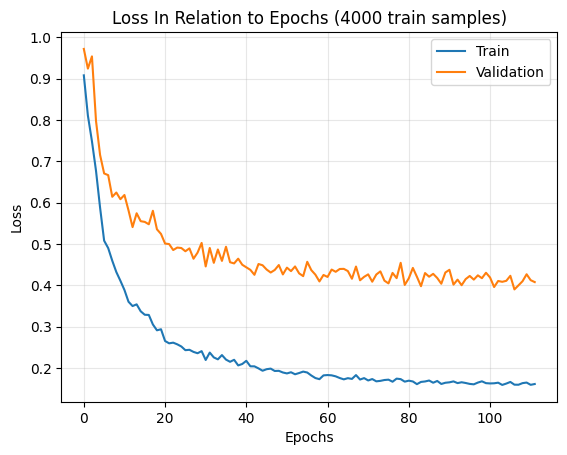

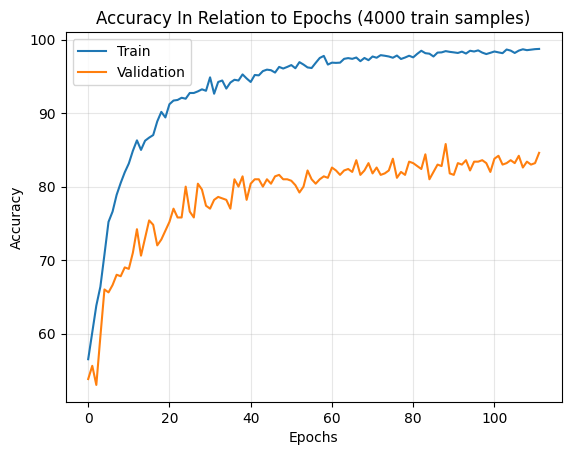

SUM OF WEIGHTS: 2512.697496496036


In [165]:
logistic.test()
print(f"SUM OF WEIGHTS: {sum(abs(logistic.weights))}")

In [ ]:
data.labels.count(0)

2509

In [116]:
for k in logistic.weights:
    print(k)

0.051215489604372166
0.769844541979672
-0.006960462990619497
-1.6362430182848884
0.3642201781241137
1.4912444189617708
-0.004571182112598493
-1.8377166892686478
0.2875868965953881
0.5356215847396183
-0.2548329483858066
-0.7745383030789105
0.2714629706790815
1.5251234711208272
0.3023050662571242
-1.4626171346405759
-1.0515403375172603
1.0118278149766664
-0.0004001948401801039
-1.4670910847971108
-0.1221523018731291
1.6994313695169305
0.08327756938333596
-2.3610955607540447
-1.1752248366415774
1.64760957840078
0.3430494983191093
-1.208309872209287
0.03305211396096439
1.909201921904157
0.09080187228013982
-1.0043037820633365
0.428239186346619
2.3889349775683404
-0.38950130485423345
-1.2773476875662721
-0.7647158358740013
2.2355410640865845
0.07605684233899788
-1.2716038179189428
-0.14894680728704532
1.1335241317225506
-0.4882196017487887
-1.3211256353453122
-1.0646716651328088
1.2051037473817185
-0.7112574007637882
-2.1116590483289865
0.8799203882353889
0.4719910676514203
0.35495987253671